In [4]:
!pip install pandas numpy seaborn matplotlib scikit-learn pyspark kagglehub wordcloud

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, lower, concat, lit, slice, rpad, when, size, array_repeat, explode, col, count, struct, array, concat_ws
from pyspark.sql.types import ArrayType, IntegerType, DoubleType
import kagglehub
import os
from pyspark.ml.feature import Tokenizer, StopWordsRemover, RegexTokenizer, VectorAssembler
from transformers import BertTokenizerFast
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import length
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark import SparkContext
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import ConfusionMatrixDisplay
from google.colab import files

In [6]:
files.upload()
os.makedirs("~/.kaggle")
os.rename("/content/kaggle.json", "~/.kaggle/kaggle.json")
path = kagglehub.dataset_download("kritanjalijain/amazon-reviews")

Saving kaggle.json to kaggle.json


In [7]:
print(path)

/kaggle/input/amazon-reviews


In [8]:
#Initialize Spark session
spark = SparkSession.builder.appName("AmazonReviewPolarity") \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "100g") \
    .config("spark.executor.cores", "4") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.shuffle.spill", "true") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
print("Apache Spark Initialized Successfully!")

Apache Spark Initialized Successfully!


In [9]:
# Read data
train_df = spark.read.csv(f"{path}/train.csv", header=False, inferSchema=True)
test_df = spark.read.csv(f"{path}/test.csv", header=False, inferSchema=True)

In [10]:
#Rename columns
train_df_columns, test_df_columns = train_df.columns, test_df.columns

train_df = train_df.withColumnRenamed("_c0", "label") \
                   .withColumnRenamed("_c1", "title") \
                   .withColumnRenamed("_c2", "body")

test_df = test_df.withColumnRenamed("_c0", "label") \
                 .withColumnRenamed("_c1", "title") \
                 .withColumnRenamed("_c2", "body")

In [11]:
# Show 5 instances of data
train_df.show(5, truncate=100)
test_df.show(5, truncate=100)

+-----+------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|label|                                                 title|                                                                                                body|
+-----+------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|    2|                        Stuning even for the non-gamer|This sound track was beautiful! It paints the senery in your mind so well I would recomend it eve...|
|    2|                 The best soundtrack ever to anything.|I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'...|
|    2|                                              Amazing!|"This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners...|
|    2|         

In [12]:
# Drop NA values in Data
train_df = train_df.dropna().dropDuplicates() \
             .withColumn("title", trim(col("title"))) \
             .withColumn("body", trim(col("body")))
test_df = test_df.dropna().dropDuplicates() \
             .withColumn("title", trim(col("title"))) \
             .withColumn("body", trim(col("body")))

In [13]:
train_df_try = train_df
test_df_try = test_df

In [14]:
# Perform initial data cleaning
train_df_cleaned = train_df.dropna().dropDuplicates() \
    .withColumn("title", trim(col("title"))) \
    .withColumn("body", trim(col("body")))

In [15]:
# Repartition the cleaned training DataFrame
train_partitioned_df = train_df_cleaned.repartition(5)

In [16]:
# Find number of records in each partition
train_partition_sizes = train_partitioned_df.rdd.glom().map(len).collect()


Training Data Distribution Across Partitions:
[719932, 719931, 719920, 719917, 719922]


<ipython-input-17-ab8e8215ec0b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1, len(train_partition_sizes) + 1)),


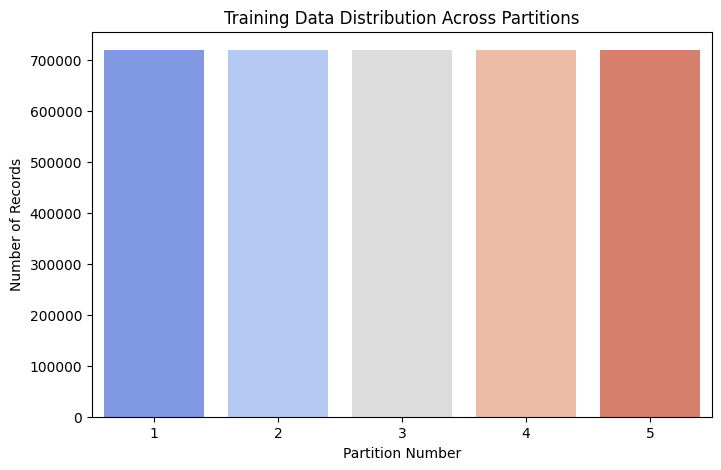

In [17]:
# Plot the number of instances in each partition

print("\nTraining Data Distribution Across Partitions:")
print(train_partition_sizes)

plt.figure(figsize=(8, 5))
sns.barplot(x=list(range(1, len(train_partition_sizes) + 1)),
            y=train_partition_sizes, palette='coolwarm')
plt.xlabel("Partition Number")
plt.ylabel("Number of Records")
plt.title("Training Data Distribution Across Partitions")
plt.show()

In [18]:
# Replace classes of 1 and 2 with 0 and 1 for easier interpretation
train_df = train_df.withColumn("label", when(col("label") == 1, 0).otherwise(1))
test_df = test_df.withColumn("label", when(col("label") == 1, 0).otherwise(1))
train_df.select("label").distinct().show()
test_df.select("label").distinct().show()

+-----+
|label|
+-----+
|    1|
|    0|
+-----+

+-----+
|label|
+-----+
|    1|
|    0|
+-----+



In [19]:
# Print first 5 rows to confirm the change
train_df.show(5, truncate=50)
test_df.show(5, truncate=100)

+-----+--------------------------------------------------+--------------------------------------------------+
|label|                                             title|                                              body|
+-----+--------------------------------------------------+--------------------------------------------------+
|    0|                                        NOT FUNNY!|This is what Hollywood is calling humor these d...|
|    0|                                    Edge of Danger|Somebody from higher places should have stopped...|
|    1|                       Great classic for the price|For a first time reading of this classic I reco...|
|    1|                                         Great Buy|I was looking for clarity and a picture that wo...|
|    0|The adapter shown is not the one that was shipped.|I received a different adapter so I cannot real...|
+-----+--------------------------------------------------+--------------------------------------------------+
only showi

In [20]:
# Make all words small letter for making tokenization better in later part
train_df = train_df.withColumn("title_lower", lower(col("title"))) \
    .withColumn("body_lower", lower(col("body")))

test_df = test_df.withColumn("title_lower", lower(col("title"))) \
    .withColumn("body_lower", lower(col("body")))

In [21]:
# Tokenize the title
tokenizer_title = RegexTokenizer(inputCol="title_lower", outputCol="title_tokens", pattern="\\W+")
train_df = tokenizer_title.transform(train_df)
test_df = tokenizer_title.transform(test_df)

In [22]:
# Tokenize the body

tokenizer_body = RegexTokenizer(inputCol="body_lower", outputCol="body_tokens", pattern="\\W+")
train_df = tokenizer_body.transform(train_df)
test_df = tokenizer_body.transform(test_df)

In [23]:
# Remove stop words from title
stop_words_remover_title = StopWordsRemover(inputCol="title_tokens", outputCol="title_clean")
train_df = stop_words_remover_title.transform(train_df)
test_df = stop_words_remover_title.transform(test_df)

In [24]:
# Remove stop words from body
stop_words_remover_body = StopWordsRemover(inputCol="body_tokens", outputCol="body_clean")
train_df = stop_words_remover_body.transform(train_df)
test_df = stop_words_remover_body.transform(test_df)

In [25]:
train_df.show(5, truncate=100)
test_df.show(5, truncate=100)

+-----+--------------------------------------------------+----------------------------------------------------------------------------------------------------+--------------------------------------------------+----------------------------------------------------------------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------+------------------------------+----------------------------------------------------------------------------------------------------+
|label|                                             title|                                                                                                body|                                       title_lower|                                                                                          body_lower|                                                title_tokens|                      

In [26]:
# convert text to bag-of-words
from pyspark.ml.feature import CountVectorizer

count_vect_body = CountVectorizer(inputCol="body_clean", outputCol="body_bow")
cv_model = count_vect_body.fit(train_df)
bow_df = cv_model.transform(train_df)

In [27]:
bow_df.select("body", "body_clean" ,"body_bow").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
# show most frequent word
vocab = cv_model.vocabulary
print("First 10 terms (by frequency):", vocab[:10])
print("Vocabulary size:", len(vocab))

First 10 terms (by frequency): ['book', 'one', 'like', 'good', 'great', 'get', 'read', 'time', 'really', 'movie']
Vocabulary size: 262144


In [29]:
# Take a small sample
from pyspark.sql import functions as F
df_small = bow_df.orderBy(F.rand(seed=42)).limit(10000)

In [30]:
## KMeans model for multiple k to collect SSE for elbow method
from pyspark.ml.clustering import KMeans
k_values = range(4,17,4)
SSE_results = []

for k in k_values:
    kmeans = KMeans(
        k=k,
        initMode="k-means||",
        maxIter=20,
        tol=1e-3,
        seed=2,
        featuresCol="body_bow"
    )
    model = kmeans.fit(df_small)
    SSE = model.summary.trainingCost
    SSE_results.append(SSE)
    print(f"k={k}: SSE = {SSE}")

k=4: SSE = 412472.931894204
k=8: SSE = 410076.01917792147
k=12: SSE = 408487.591079329
k=16: SSE = 407746.2503831534


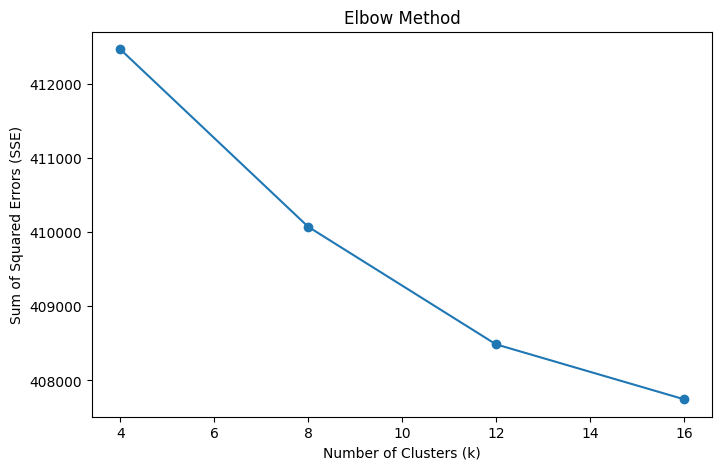

In [31]:
#Elbow method to choose optimal k
plt.figure(figsize=(8, 5))
plt.plot(list(k_values), SSE_results, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method")
plt.show()

In [32]:
# Train k means model with optimal k
from pyspark.ml.clustering import KMeans

kmeans = KMeans(
    k=12,
    initMode="k-means||",
    seed=99,
    featuresCol="body_bow"
)

model = kmeans.fit(df_small)


In [33]:
# Get cluster centers and labels
cluster_centers = model.clusterCenters()

clustered_df = model.transform(df_small)

labels = clustered_df.select("prediction").rdd.flatMap(lambda x: x).collect()

In [34]:
# Show sample predictions
clustered_df.select("body_clean", "prediction").show(5)

+--------------------+----------+
|          body_clean|prediction|
+--------------------+----------+
|[book, really, re...|         2|
|[read, john, barn...|         0|
|[picked, specials...|         0|
|[cheaply, made, l...|         0|
|[love, fountain, ...|         1|
+--------------------+----------+
only showing top 5 rows



In [35]:
# count the number of documents per cluster
from pyspark.sql.functions import count

cluster_counts = clustered_df.groupBy("prediction").agg(count("body").alias("count"))

cluster_counts.orderBy("prediction").show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 4585|
|         1| 1033|
|         2| 1053|
|         3| 1024|
|         4|  433|
|         5|  987|
|         6|    1|
|         7|  333|
|         8|  548|
|         9|    1|
|        10|    1|
|        11|    1|
+----------+-----+



In [36]:
# Show top terms per cluster
index_to_word = {i: word for i, word in enumerate(vocab)}

print("Top terms per cluster:")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}:", end='')

    top_indices = np.argsort(center)[::-1][:10]
    for ind in top_indices:
        term = index_to_word.get(ind, "???")
        print(f' {term}', end='')
    print()

Top terms per cluster:
Cluster 0: like good book one well much time get love even
Cluster 1: great like one really good book get love much price
Cluster 2: book read one good like reading really much time great
Cluster 3: one like get time good first well new much even
Cluster 4: album cd like songs music good song one really great
Cluster 5: product use time get like good work 2 even bought
Cluster 6: washed price hand champagne worth glasses nice along thoughtful wrapped
Cluster 7: movie good one like film time great story first movies
Cluster 8: read book books one story like good really reading time
Cluster 9: movie girl come ok terry ve still funny surprises weeks
Cluster 10: files flash drive copying cd burning terms backups works xp
Cluster 11: father believe good tale sent right little restore women grows


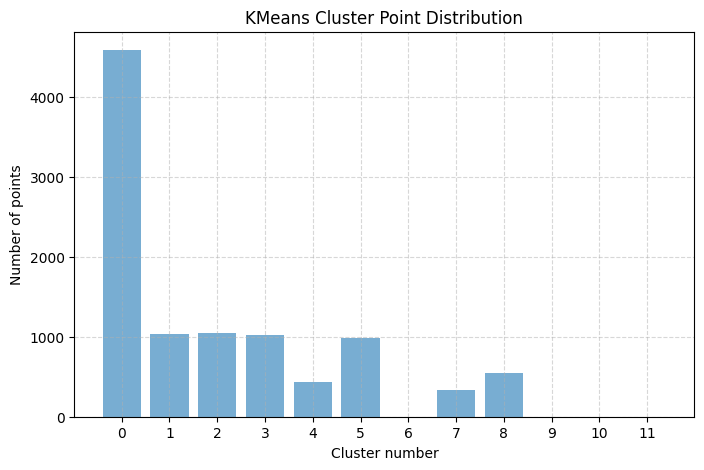

In [37]:
# Plot cluster distribution
cluster_counts_pd = cluster_counts.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(cluster_counts_pd["prediction"], cluster_counts_pd["count"], alpha=0.6)
plt.title('KMeans Cluster Point Distribution')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.xticks(cluster_counts_pd["prediction"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [38]:
# Show one sample reviews per cluster
cluster_ids = [row['prediction'] for row in clustered_df.select("prediction").distinct().collect()]

print("Sample reviews per cluster:\n" + "="*40)
for cluster_id in cluster_ids:
    print(f"A review assigned to cluster {cluster_id}")
    print("-" * 70)

    sample_review = clustered_df.filter(col("prediction") == cluster_id).select("body").limit(1).collect()

    if sample_review:
        print(sample_review[0]["body"])
    else:
        print("No review found in this cluster.")

    print("\n" + "_" * 70)

Sample reviews per cluster:
A review assigned to cluster 2
----------------------------------------------------------------------
When a book is really, really, really bad I throw it across the room. This book took its maiden flight at 11:00pm on a Saturday night on around page 85. I am going to give this book to my brother Lonnie because he keeps giving me horrible books. If he reads this...great - He will save himself from wasting a few hours. If he doesn't - I figure I owe him anyway.

______________________________________________________________________
A review assigned to cluster 0
----------------------------------------------------------------------
If I had not read any other John Barnes novels before this I might not have bothered and would have missed the brilliance of Mother of Storms, Orbital Resonance & Kaleidascope Century. This is a dull reworking of the 'Moon is a Harsh Mistress ' plot, with a bit of Charles Sheffield's 'Heritage' series thrown in at the end. Don't mi

In [39]:
# examine specific cluster samples
cluster_7_reviews = clustered_df.filter(col("prediction") == 7).select("body").orderBy(F.rand()).limit(3)

print("Sample reviews from Cluster 7:")
cluster_7_reviews.show(truncate=False)

Sample reviews from Cluster 7:
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|body                                                                                                                                                                                                                                                                                                                                                                                                          